In [56]:
import numpy as np
import easier as ezr
import pylab as pl
import pandas as pd
import numpy as np
import itertools
from string import ascii_lowercase
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

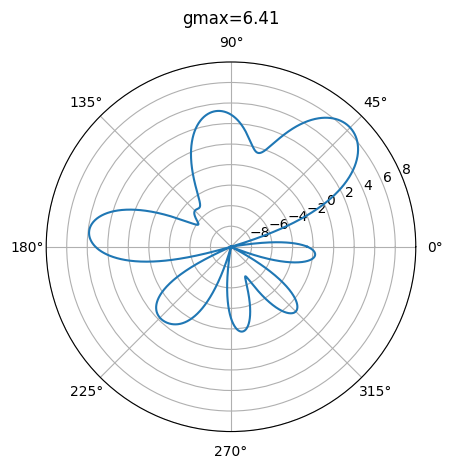

In [113]:
class Element:
    c = 3e8
    def __init__(self, freq, r0_vector_in_wavelengths, phase=0, name=''):
        self.phi0 = phase 
        self.f = freq
        self.lamda = self.c / self.f
        self.k = 2 * np.pi / self.lamda
        self.r0 = self.lamda * np.array(r0_vector_in_wavelengths)
        self.name = name
        
    def phase_to(self, r_vector):
        R_vector = np.array(r_vector) - self.r0
        R_mag = np.sqrt(np.sum(R_vector ** 2, axis=-1))
        phase = self.k * R_mag
        val = np.exp(1j * (phase - self.phi0))
        val = val * (1 - .5 * np.random.rand())
        return val
    
    @ezr.cached_property
    def r(self):
        return np.sqrt(np.sum(self.r0 ** 2)) / self.lamda
    
    def set_phase(self, phase):
        self.phi0 = phase
    
    
class Array:
    def __init__(self, freq, coords, names=None):
        """
        args = list of lists.  [[x1, y1, phase_radians1], ... [xN, yN, phase_radiansN]]
        """
        if names is None:
            names = ['' for c in coords]
        self.elements = [Element(freq, coord, name=name) for (coord, name) in zip(coords, names)]
        
    def plot_elements(self):
        x = []
        y = []
        names = []
        for el in self.elements:
            x.append(el.r0[0] / el.lamda)
            y.append(el.r0[1] / el.lamda)
            names.append(el.name)
            
        ax = ezr.figure(figsize=(3, 3), grid=False)
        ax.scatter(x, y)
        
        for (xi, yi, name) in zip(x, y, names):
            if name:
                ax.text(xi, yi, name, ha='left', va='bottom', size='large')
        ax.axis('square')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    def plot_pattern(self, show=True):
        r = 1000 * max([e.r for e in self.elements])
        phi = np.linspace(0, 2 * np.pi, 3000)
        x_vals = r * np.cos(phi)
        y_vals = r * np.sin(phi)
        XY = np.vstack((x_vals, y_vals)).T
        
        Z = np.zeros_like(phi)
        for element in self.elements:
            Z = Z + element.phase_to(XY)
            
        P = (np.conj(Z) * Z).real
        P = P / np.mean(P)
        
        P = 10 * np.log10(P + 1e-6)
        P = np.maximum(P, -20)

        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(phi, P)
        ax.grid(True)
        
        min_val = np.max([-10, np.floor(np.min(P)) - 1])
        max_val = np.ceil(np.max(P)) + 1
        ax.set_ylim(min_val, max_val)
        ax.set_title(f'gmax={np.round(np.max(P), 2)}', va='bottom')
        if show:
            plt.show()
        return ax
        
        
        
class DeltaArray(Array):
    def __init__(self, freq, side_in_wavelengths=.25):
        k = 2 * np.pi
        s = side_in_wavelengths
        self.s, self.k = s, k
        
        theta_b = np.pi / 6
        
        coords = [
            [0, 0],
            [s * np.cos(theta_b), .5 * s],
            [0, s] 
        ]
        
        names = [
            'a',
            'b',
            'c',
        ]
        
        super().__init__(freq, coords, names)
        
    def plot_pattern(self, theta_degrees):
        theta = np.pi * theta_degrees / 180
        s = self.s
        k = self.k
        phase_lookup = {
            'a': 0,
            'b': -k * s * np.cos(theta - np.pi / 6),
            'c': -k * s * np.cos(theta - np.pi / 2)                     
        }
        self.phase_lookup = phase_lookup
        for element in self.elements:
            element.set_phase(phase_lookup[element.name])
        ax = super().plot_pattern(show=False)
        phase_a = np.round(phase_lookup['a'] * 180 / np.pi, 0)
        phase_b = np.round(phase_lookup['b'] * 180 / np.pi, 0)
        phase_c = np.round(phase_lookup['c'] * 180 / np.pi, 0)
        
        title = f'dir={theta_degrees} {ax.get_title()}  a={phase_a} b={phase_b} c={phase_c}'
        ax.set_title(title)
        
class RandArray(Array):
    def __init__(self, freq=7.15e6, num_elements=3, side_in_wavelengths=.25):
        k = 2 * np.pi
        s = side_in_wavelengths
        self.s, self.k = s, k
#         np.random.seed(2)
        M = np.random.rand(num_elements, 2) - .5
        M = side_in_wavelengths * M
        possible_names = [''.join(t) for t in itertools.product(list(ascii_lowercase), list(ascii_lowercase))]
        names = list(possible_names)[:M.shape[0]]
        coords = [list(M[r, :]) for r in range(M.shape[0])]
        
        self.thetas = [np.arctan2(y, x) for (x, y) in [M[r, :] for r in range(M.shape[0])]]
        
        super().__init__(freq, coords, names)
        
    def plot_pattern(self, theta_degrees):
        theta = np.pi * theta_degrees / 180
        s = self.s
        k = self.k
        for element, theta_point in zip(self.elements, self.thetas):
            r_vec = element.r0 / element.lamda
            r = np.sqrt(np.sum(r_vec ** 2))
            phi = -k * r * np.cos(theta - theta_point)
            element.set_phase(phi)
                                  
        ax = super().plot_pattern(show=False)
        
ra = RandArray(num_elements=5, side_in_wavelengths=2)
ra.plot_pattern(45)

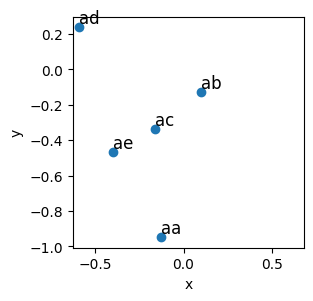

In [89]:
ra.plot_elements()

Now let's plot the radiators to make sure they actually look like an equilateral triangle

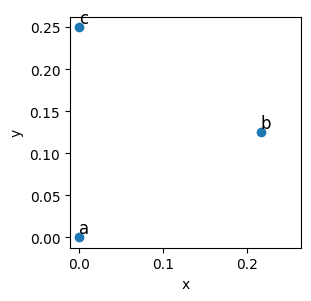

In [6]:
array.plot_elements()

That looks reasonable.  Now lets' plot the pattern for sending radiation along the x-axis

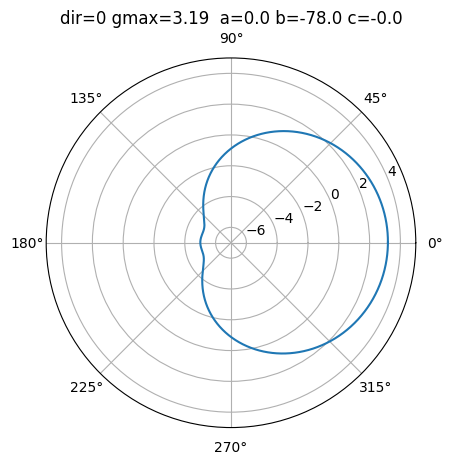

In [7]:
array.plot_pattern(theta_degrees=0)

So, this fantasy configuration of three isotropic radiators would have a maximum of 3.19 db gain along the x axis.  Cool! Note that the figure title is sayin "dir=0" which means we intended to shoot radiation at $\theta=0$.  The max gain was 3.19 db.   The phase of the **a**  and **c** radiators were zero, while the phase of the **b** radiator was -78 degrees.

Now let's try it for several other directions.

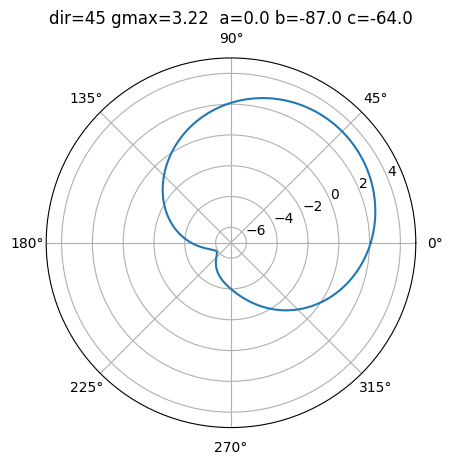

In [8]:
array.plot_pattern(theta_degrees=45)

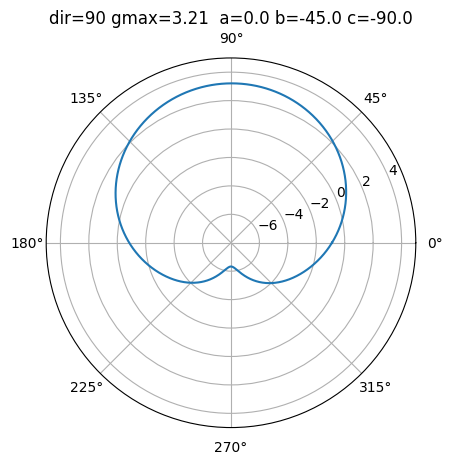

In [9]:
array.plot_pattern(theta_degrees=90)

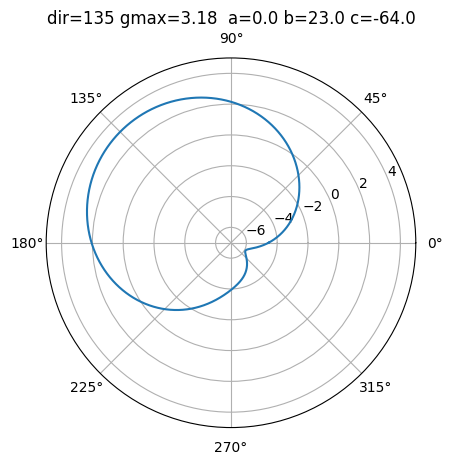

In [10]:
array.plot_pattern(theta_degrees=135)

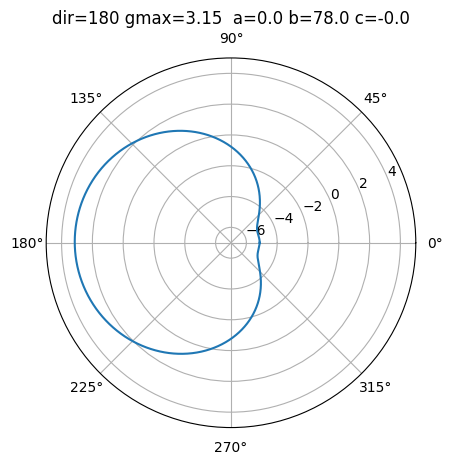

In [11]:
array.plot_pattern(theta_degrees=180)